#Image Classification using a linear model

## Download Data

In [1]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

In [2]:
# Verify connection with GPU
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


## Read Images

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [5]:
def read_and_decode(filename, reshape_dims):
  # Bytes Seq
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  # Convert Int [0, 255] to float
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size, example: tf.image.resize(img, [256, 128])
  return tf.image.resize(img, reshape_dims)

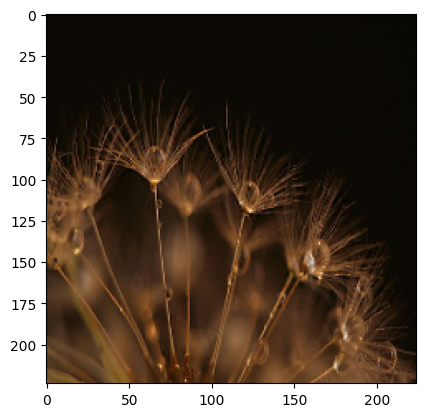

In [6]:
def show_image(filename):
  # Read and decode img
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # Convert TF to numpy and show image
  plt.imshow(img.numpy())

show_image("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg")

In [7]:
# Get specific class
dandelion = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/*.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/10477378514_9ffbcec4cf_m.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/10486992895_20b344ce2d_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/10617162044_8740d4dd9f_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/10617191174_9a01753241_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/10683189_bd6e371b97.jpg


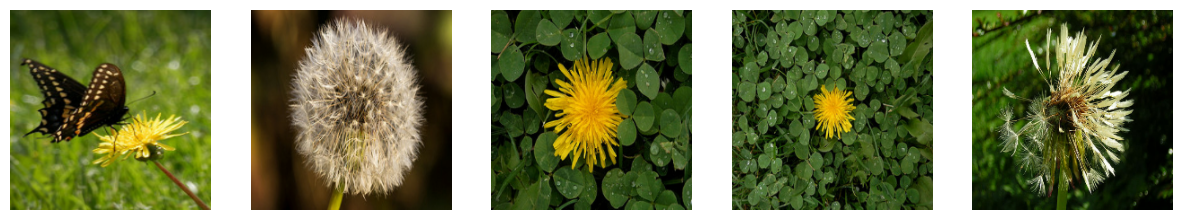

In [8]:
# Visualize images
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(dandelion[5:10]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [9]:
# Get all data
# tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*/*.jpg")

## Get Labels

In [10]:
# Get basename with regex_replace(input, pattern, rewrite)
basename = tf.strings.regex_replace("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/*.jpg",
                                    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/",
                                    "")
basename

<tf.Tensor: shape=(), dtype=string, numpy=b'dandelion/*.jpg'>

In [11]:
# Split string with split(string, sep)
label = tf.strings.split(basename, "/")[0]
label

<tf.Tensor: shape=(), dtype=string, numpy=b'dandelion'>

In [12]:
CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("Available classes:", CLASS_NAMES)

Available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


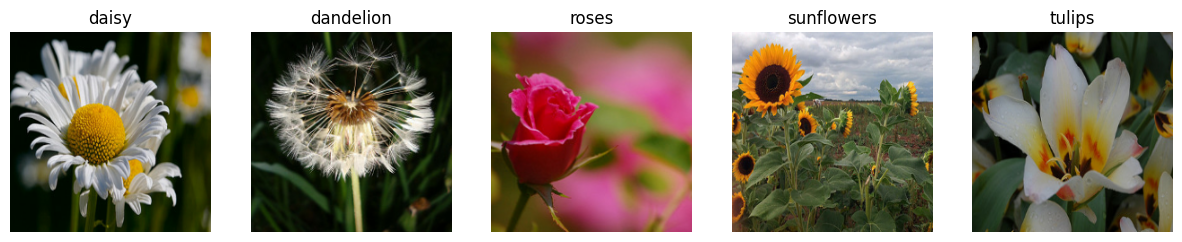

In [13]:
files_paths = [
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(files_paths):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

## Reading Train and Test

In [16]:
train_set = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
eval_set = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"

In [20]:
def decode_csvline(csv_row):
  record_defaults = ["path", "flower"]
  # Get filename and label
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  # Get image, convert TF Float32, 3 Channels and Reshape Dims
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  # Return the image and label
  return img, label

In [21]:
dataset = (tf.data.TextLineDataset(train_set).map(decode_csvline))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

tf.Tensor(0, shape=(), dtype=int64) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


## Linear Model

Given a new image, we can compute the weighted average of all its pixel values. We can then use this value to choose between the five types of flowers. Therefore, we will compute five such weighted averages (so that we are actually learning width * height * 3 * 5 weight values), and choose the flower type based on which output is the largest.

<center>$Y_{j} = b_{j} + \sum_{rows} \sum_{columns} \sum_{channels} (w_{i} * x_{i})$</center>

In [23]:
train_dataset = (tf.data.TextLineDataset(train_set).map(decode_csvline)).batch(10)
eval_dataset = (tf.data.TextLineDataset(eval_set).map(decode_csvline)).batch(10)

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.Dense(5, activation='softmax') #Num Classes
])

In [25]:
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


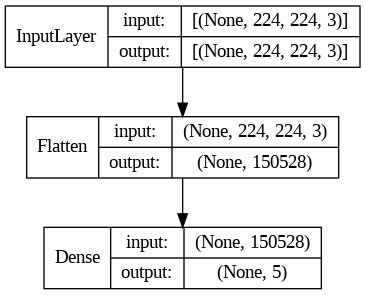

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

**Note**: 2 hrs estimated

In [28]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 741s 2s/step - loss: 16.1014 - accuracy: 0.3406 - val_loss: 19.8936 - val_accuracy: 0.4135
Epoch 2/10
330/330 [==============================] - 689s 2s/step - loss: 13.6574 - accuracy: 0.4179 - val_loss: 21.6338 - val_accuracy: 0.4189
Epoch 3/10
330/330 [==============================] - 685s 2s/step - loss: 13.8749 - accuracy: 0.4582 - val_loss: 26.9680 - val_accuracy: 0.3568
Epoch 4/10
330/330 [==============================] - 689s 2s/step - loss: 14.6216 - accuracy: 0.4718 - val_loss: 27.5093 - val_accuracy: 0.4000
Epoch 5/10
330/330 [==============================] - 768s 2s/step - loss: 16.4351 - accuracy: 0.4694 - val_loss: 26.4152 - val_accuracy: 0.3595
Epoch 6/10
330/330 [==============================] - 748s 2s/step - loss: 13.0888 - accuracy: 0.5294 - val_loss: 21.5269 - val_accuracy: 0.4081
Epoch 7/10
330/330 [==============================] - 784s 2s/step - loss: 11.0088 - accuracy: 0.5636 - val_loss: 17.8355 - val_ac

In [29]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

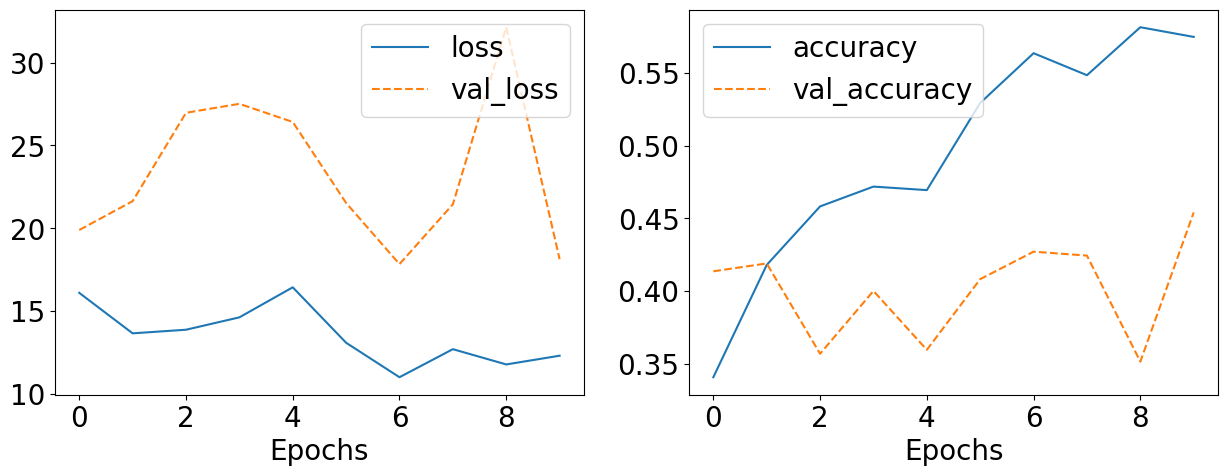

In [30]:
training_plot(['loss', 'accuracy'], history);

## Single prediction

In [51]:
file_n = 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg'
img = read_and_decode(file_n, [IMG_HEIGHT, IMG_WIDTH])
pred = model.predict(tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, 3]))[0]

1/1 [==============================] - 0s 31ms/step


In [52]:
pred

array([1.4333887e-10, 1.0000000e+00, 1.2736540e-30, 8.7535993e-21,
       7.8682101e-25], dtype=float32)

In [53]:
pred_label_index = tf.math.argmax(pred)
print(f'Index: {pred_label_index}')
pred_label = CLASS_NAMES[pred_label_index]
print(f'Class: {pred_label}')

Index: 1
Class: dandelion


In [57]:
# Prob
prob = tf.math.softmax(pred)
prob.numpy()

array([0.1488476 , 0.40460968, 0.1488476 , 0.1488476 , 0.1488476 ],
      dtype=float32)

1/1 [==============================] - 0s 37ms/step


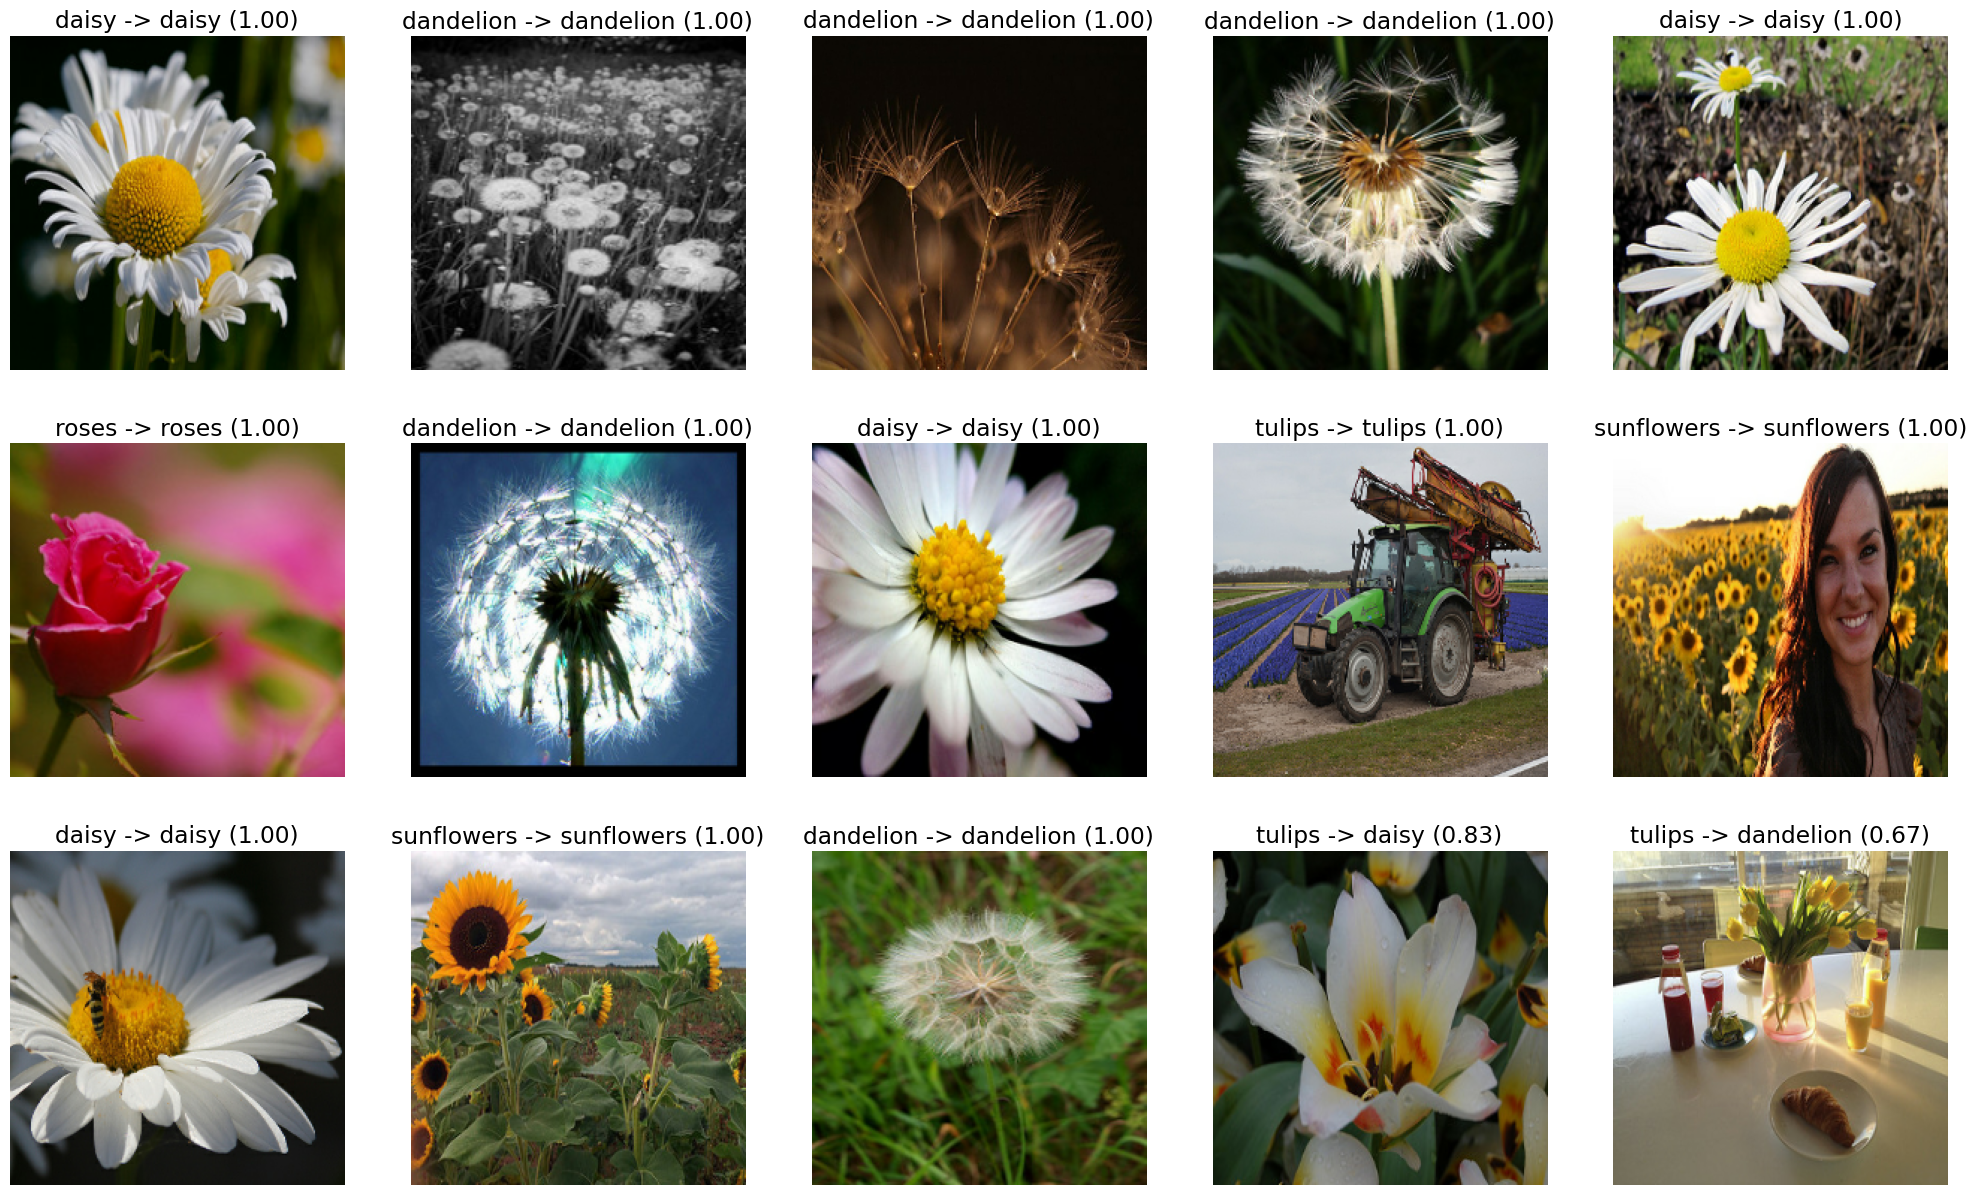

In [58]:
# Call our model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csvline))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

1/1 [==============================] - 0s 18ms/step


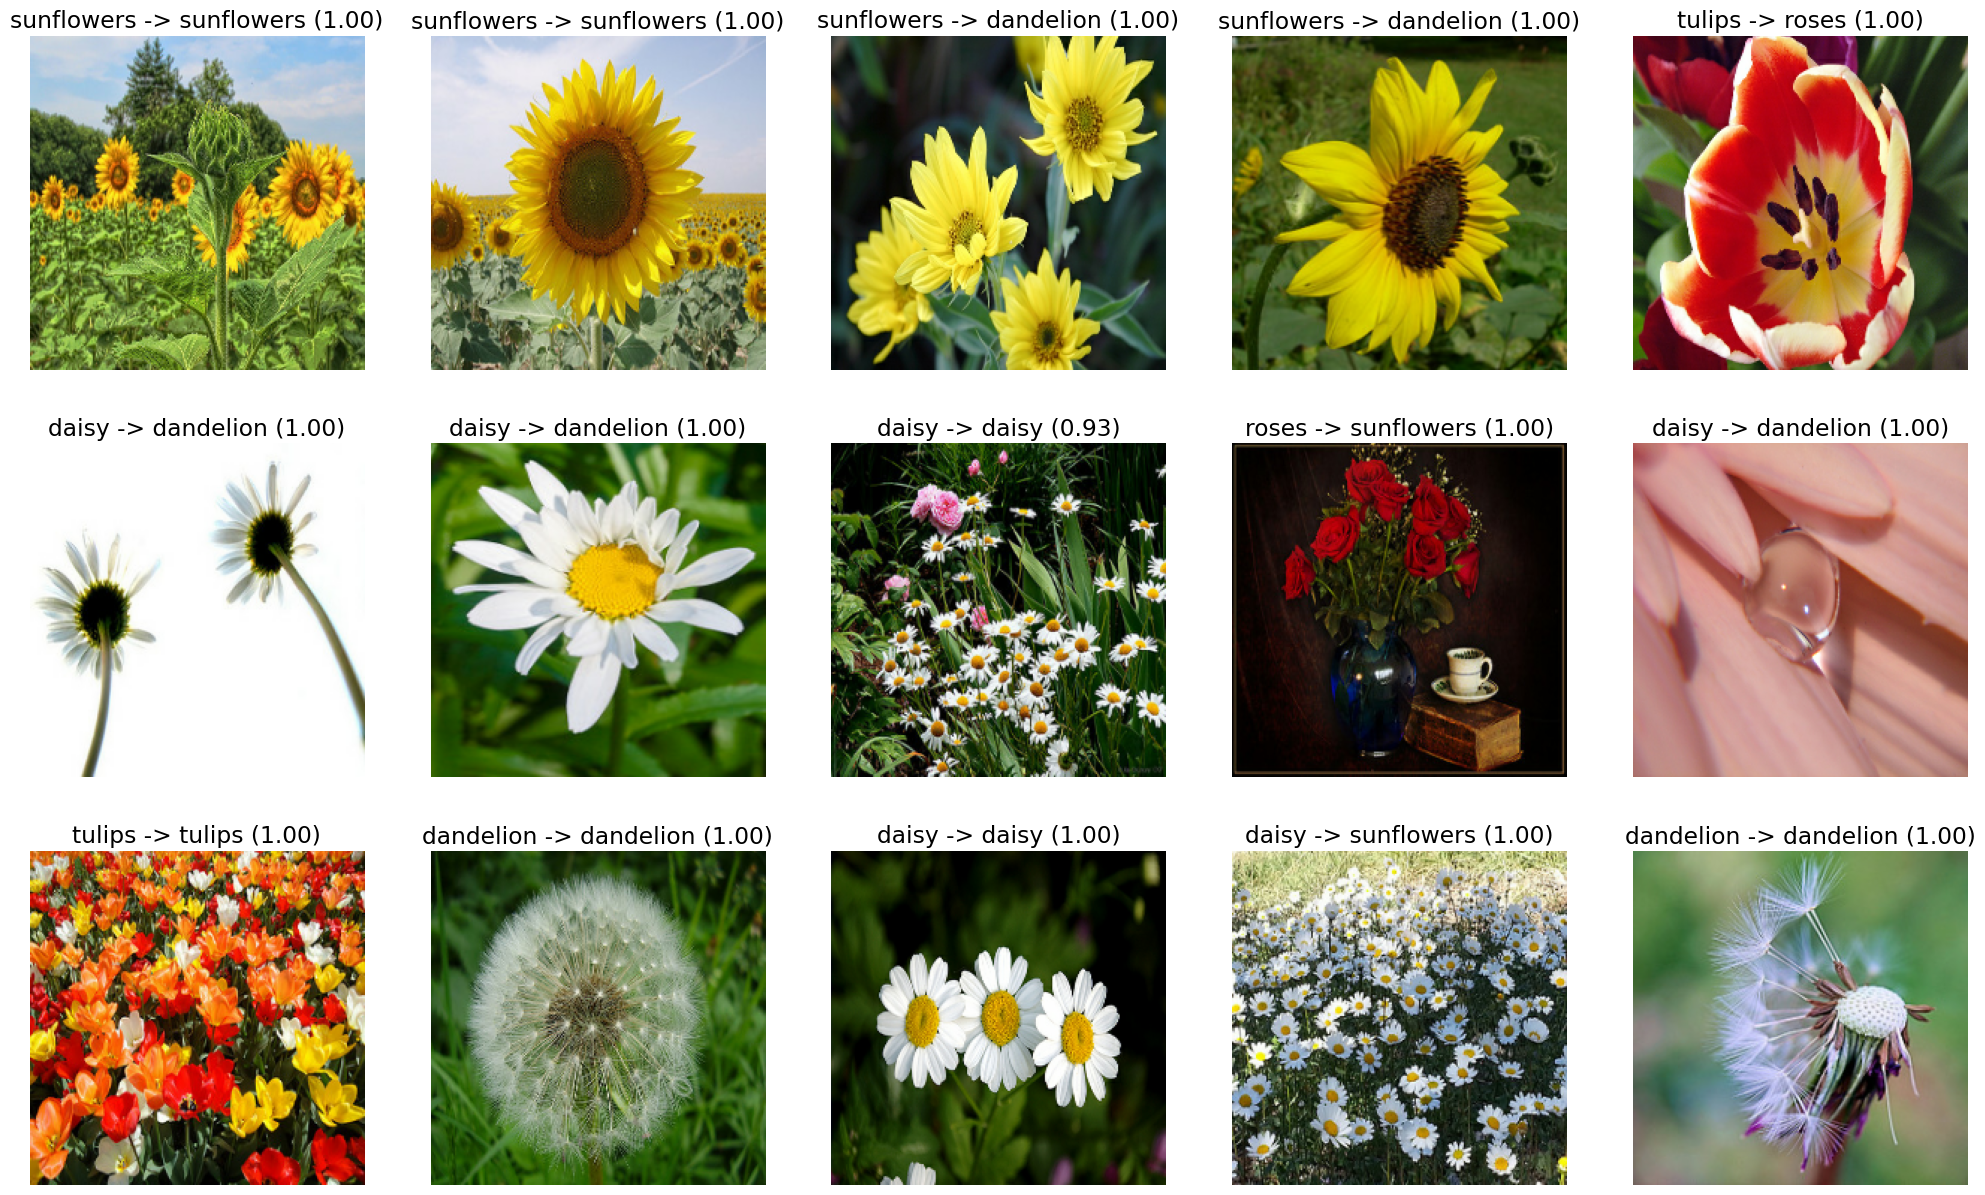

In [59]:
# Evaluation Set
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")